# Profit-driven pre-processing in B2B customer churn modeling using fairness techniques
This notebook is associated with the paper "Profit-driven pre-processing in B2B customer churn modeling using fairness techniques" by Shimanto Rahman, Bram Janssens & Matthias Bogaert, published in the Journal of Business Research. The pre-processing techniques—resampling, reweighing, and massaging—are applied to an open source customer churn dataset and evaluated with the EMPB and AUEPC metrics. Note that this open-source dataset is synthetic and does not contain the inverse churn-CLV relationship that is present in the real-world datasets used in the paper. Therefore, the results are not representative of the results in the paper, but are meant to demonstrate the implementation of the techniques.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import TargetEncoder
from empulse.metrics.churn import empb_score, auepc_score
from empulse.models import BiasRelabelingClassifier, BiasResamplingClassifier, BiasReweighingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. Load the data

In [2]:
data = pd.read_excel('data/Telco_customer_churn.xlsx', 'Telco_Churn')
data = data.drop(
    columns=['Count', 'Country', 'State', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Reason',
             'Churn Score', 'Churn Label']
)

# normalize column names
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns = data.columns.str.replace('customerid', 'id').str.replace('cltv', 'clv')

# convert data types
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')
data['total_charges'] = data['total_charges'].fillna(0)
object_columns = data.select_dtypes(include='object').columns
data[object_columns] = data[object_columns].astype('category')
data = data.set_index('id')

X = data.drop(columns=['churn_value', 'clv'])
y = data['churn_value']
clv = data['clv']


# 2. Split the data stratified by churn and clv

In [3]:
# Create a stratification key by combining 'churn_value' and 'clv' into a single column
stratify_key = pd.qcut(clv, q=4, labels=False, duplicates='drop') * 10 + y

# Initialize the StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_index, test_index in split.split(X, stratify_key):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clv_train, clv_test = clv.iloc[train_index], clv.iloc[test_index]

# define high-clv and low-clv customers based on the 66th percentile
high_clv_train = clv_train > clv_train.quantile(0.66)
high_clv_test = clv_test > clv_train.quantile(0.66)

# 3. Train the models

In [4]:
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['category', 'object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Define the transformers for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]
        ), numeric_cols),
        ('cat', Pipeline(
            steps=[
                ('target_encoder', TargetEncoder())
            ]
        ), categorical_cols)
    ]
)

# Define the pipelines
baseline_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=500, random_state=42))
    ]
)

resampling_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', BiasResamplingClassifier(
            estimator=RandomForestClassifier(n_estimators=500, random_state=42),
        ))
    ]
)

massaging_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', BiasRelabelingClassifier(
            estimator=RandomForestClassifier(n_estimators=500, random_state=42),
        ))
    ]
)

reweighing_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', BiasReweighingClassifier(
            estimator=RandomForestClassifier(n_estimators=500, random_state=42),
        ))
    ]
)

In [5]:
baseline_pipeline.fit(X_train, y_train)
resampling_pipeline.fit(X_train, y_train, classifier__protected_attr=high_clv_train)
massaging_pipeline.fit(X_train, y_train, classifier__protected_attr=high_clv_train)
reweighing_pipeline.fit(X_train, y_train, classifier__protected_attr=high_clv_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tenure_months', 'monthly_charges', 'total_charges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  Index(['city', 'gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method'],
      dtype='object'))])),
                ('classifier',
                 BiasReweighingClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                                           random_state=42)))])

# 4. Evaluate the models
## 4.1 EMPB

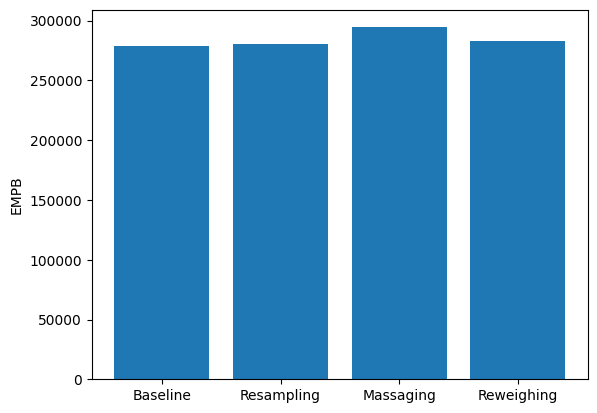

In [6]:
y_pred_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]
y_pred_resampling = resampling_pipeline.predict_proba(X_test)[:, 1]
y_pred_massaging = massaging_pipeline.predict_proba(X_test)[:, 1]
y_pred_reweighing = reweighing_pipeline.predict_proba(X_test)[:, 1]

# Calculate the EMPB scores
empb_baseline = empb_score(y_test, y_pred_baseline, clv=clv_test)
empb_resampling = empb_score(y_test, y_pred_resampling, clv=clv_test)
empb_massaging = empb_score(y_test, y_pred_massaging, clv=clv_test)
empb_reweighing = empb_score(y_test, y_pred_reweighing, clv=clv_test)

# plot the EMPB scores
plt.bar(
    ['Baseline', 'Resampling', 'Massaging', 'Reweighing'],
    [empb_baseline, empb_resampling, empb_massaging, empb_reweighing]
)
plt.ylabel('EMPB')
plt.show()

## 4.2 AUEPC

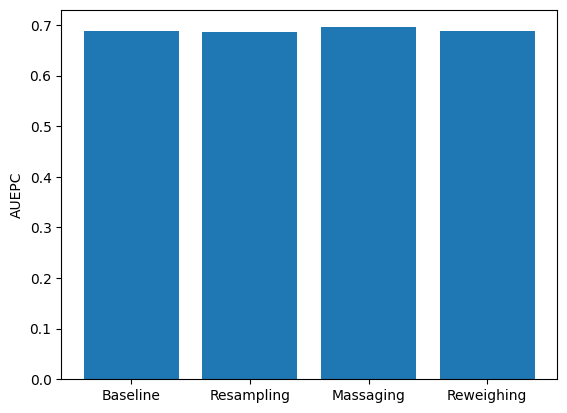

In [7]:
# Calculate the AUEPC scores
auepc_baseline = auepc_score(y_test, y_pred_baseline, clv=clv_test)
auepc_resampling = auepc_score(y_test, y_pred_resampling, clv=clv_test)
auepc_massaging = auepc_score(y_test, y_pred_massaging, clv=clv_test)
auepc_reweighing = auepc_score(y_test, y_pred_reweighing, clv=clv_test)

# Plot the AUEPC scores
plt.bar(
    ['Baseline', 'Resampling', 'Massaging', 'Reweighing'],
    [auepc_baseline, auepc_resampling, auepc_massaging, auepc_reweighing]
)
plt.ylabel('AUEPC')

plt.show()